In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_error

import warnings; warnings.simplefilter('ignore')

### Load pickle file of rookie & sophomore year statistics for all NBA players (last names A-L) in league history, scraped from [http://www.basketball-reference.com](http://basketballreference.com/)

In [6]:
with open("../pickles-csv/df.pkl", 'rb') as f:
    df = pickle.load(f)

### Data preprocessing

In [7]:
df = df.drop('Unnamed: 0', 1)

In [8]:
# Reset index so it doesn't start over each time it transitions to next letter

df = df.reset_index().drop('index', 1)

In [9]:
'''
Only count players who, as rookies: 
1) played at least 10 minutes per game, 
2) played in at least 30 total games,
3) made an NBA roster during their 2nd year.
'''

df = df[df['MPG'] > 10]
df = df[df['Games Played'] > 30]
df = df[df['Sophomore PPG'] > 0]

In [10]:
# Fill nulls in 'Steals' and '3 Pt. Attempts' with 0

df['Steals'] = df['Steals'].fillna(0)
df['3 Pt. Att'] = df['3 Pt. Att'].fillna(0)

In [11]:
'''
Drop 15 players whose scoring average decreased by more than 6 points 
during their second year (often due to injury)
'''

df = df[df['Rookie PPG'] - df['Sophomore PPG'] < 6]

### Correlations at first glance – Sophomore points per game (ppg) is target variable

In [12]:
'''
1) First takeaway – Rookie Field Goal % is not strongly linked with Sophomore P
2) Rookie Field Goal Attempts and Sophomore Points Per Game tightly correlated. Same with Rookie Minutes Per Game.
3) Rookie 3 Pt. Attempts don't predict Sophomore success, probably because 
   most player data predates the modern-NBA
'''

df.corr()

,Rookie PPG,FGA,FG_Pct,Games Played,MPG,Rebounds,Assists,Steals,3 Pt. Att,3 Pt. Pct,FT Pct,Sophomore PPG
Rookie PPG,1.000000,0.971790,0.217595,0.397458,0.885460,0.660133,0.469214,0.207195,0.137270,-0.031819,0.213785,0.798181
FGA,0.971790,1.000000,0.055650,0.380256,0.875611,0.626351,0.487746,0.167850,0.145931,-0.003683,0.197566,0.776598
FG_Pct,0.217595,0.055650,1.000000,0.179787,0.161886,0.287843,-0.098213,0.190473,-0.234291,-0.288564,-0.081926,0.166694
Games Played,0.397458,0.380256,0.179787,1.000000,0.473855,0.319038,0.274697,0.210365,0.006291,-0.056490,0.116647,0.352955
MPG,0.885460,0.875611,0.161886,0.473855,1.000000,0.652502,0.577986,0.295412,0.186361,-0.020100,0.178151,0.678009
Rebounds,0.660133,0.626351,0.287843,0.319038,0.652502,1.000000,0.018817,-0.084448,-0.224829,-0.255057,-0.187610,0.525025
Assists,0.469214,0.487746,-0.098213,0.274697,0.577986,0.018817,1.000000,0.518125,0.295963,0.103235,0.328725,0.374963
Steals,0.207195,0.167850,0.190473,0.210365,0.295412,-0.084448,0.518125,1.000000,0.308639,0.061449,0.205119,0.163900
3 Pt. Att,0.137270,0.145931,-0.234291,0.006291,0.186361,-0.224829,0.295963,0.308639,1.000000,0.497638,0.321499,0.115258
3 Pt. Pct,-0.031819,-0.003683,-0.288564,-0.056490,-0.020100,-0.255057,0.103235,0.061449,0.497638,1.000000,0.256640,0.040103


### EDA

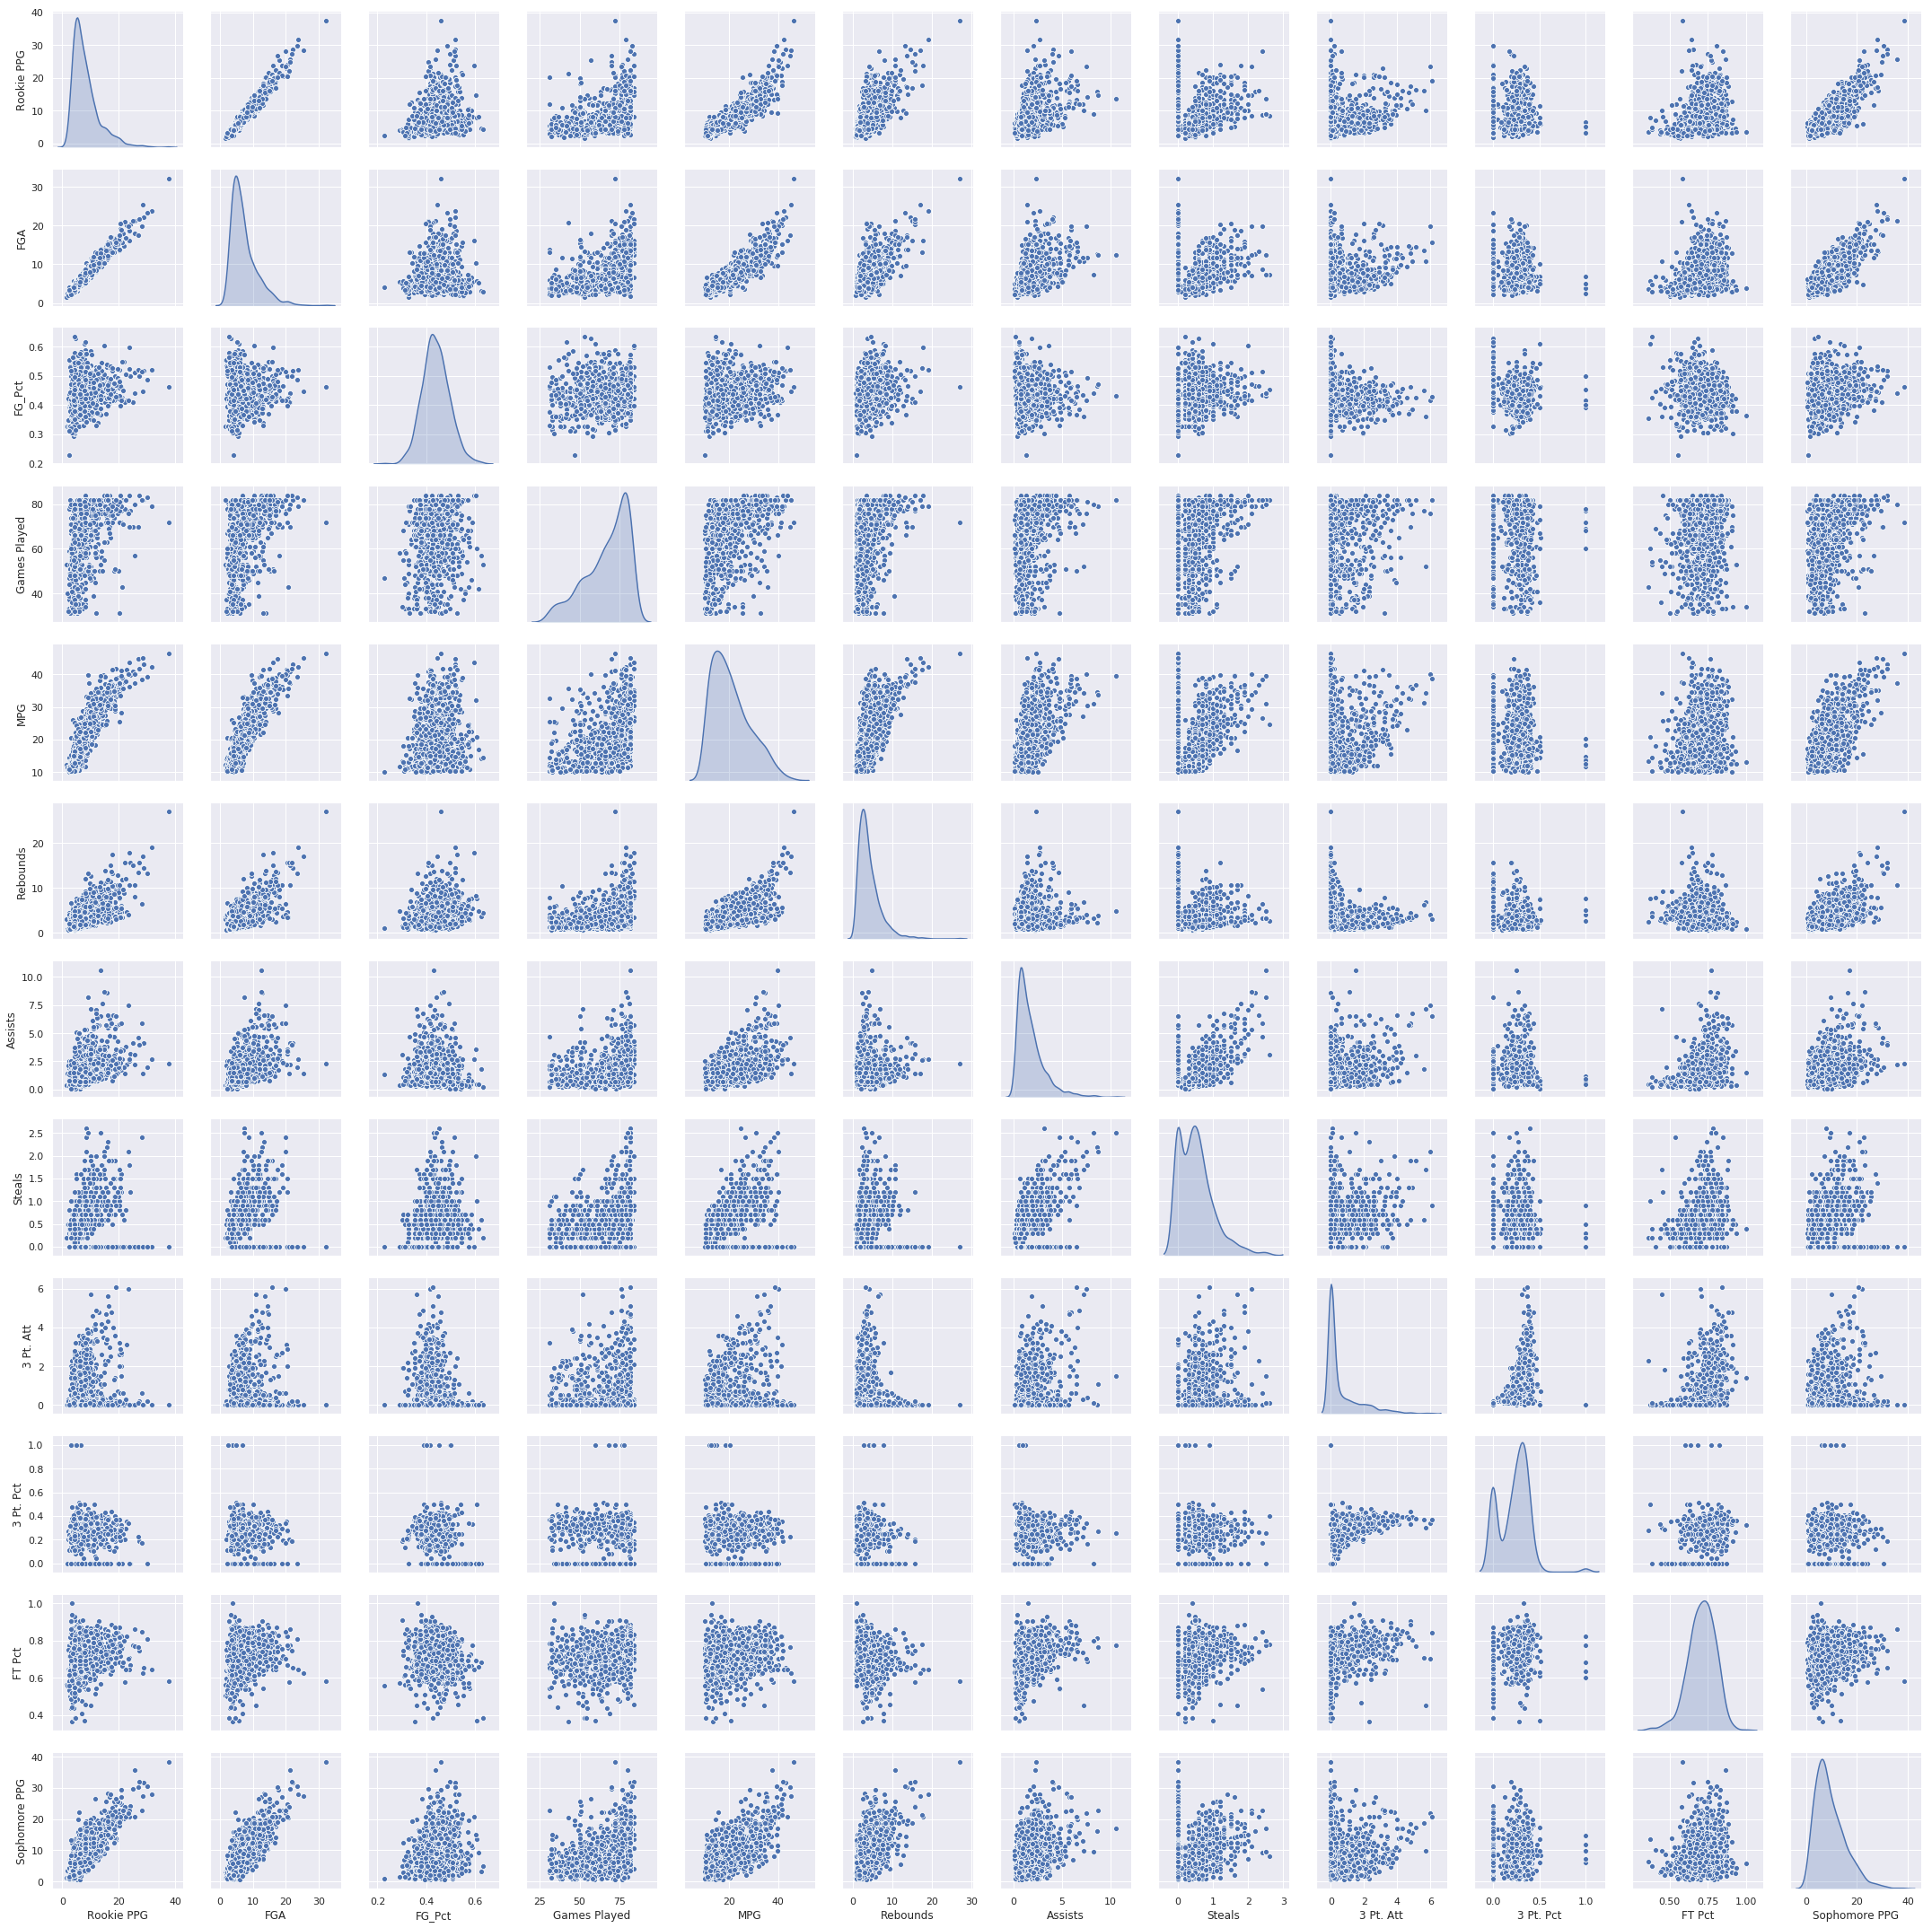

In [13]:
sns.set()
sns.pairplot(df, diag_kind='kde') # Skewed right distribution

#### Rookie year field goal percentage vs. 2nd year ppg (Surprisingly weak relationship)

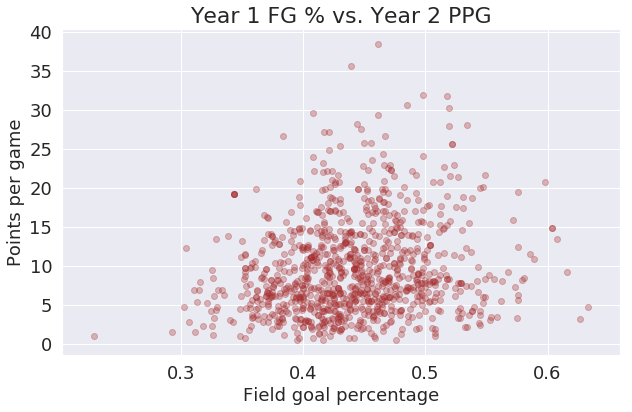

In [16]:
# Shooting percentage as a rookie not a great predictor of sophomore success

plt.figure(figsize=(10,6))

plt.scatter(df['FG_Pct'], df['Sophomore PPG'], alpha = 0.3, c='brown')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Field goal percentage', fontsize = 18)
plt.ylabel('Points per game', fontsize = 18)
plt.title('Year 1 FG % vs. Year 2 PPG', fontsize = 22);

plt.savefig('../figures/FG Pct vs. PPG.png')

#### Rookie year field goal attempts vs. 2nd year ppg (Strong relationship)

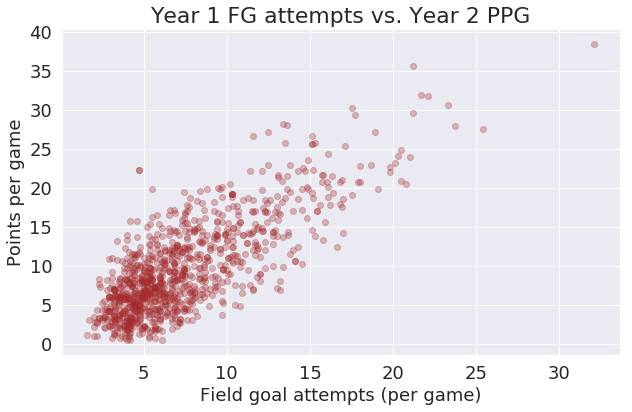

In [21]:
'''
Th opportunity to take a lot of shots is a strong predictor of sophomore success.
Coaches should allow rookie players to make mistakes. Though there may be growing pains,
the player (and team) will reap the benefits of this player development philosophy.
'''

plt.figure(figsize=(10,6))

plt.scatter(df['FGA'], df['Sophomore PPG'], alpha = 0.3, c='brown')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Field goal attempts (per game)', fontsize = 18)
plt.ylabel('Points per game', fontsize = 18)
plt.title('Year 1 FG attempts vs. Year 2 PPG', fontsize = 22);

plt.savefig('../figures/FG Att vs. PPG.png')

#### Rookie year ppg vs. 2nd year ppg

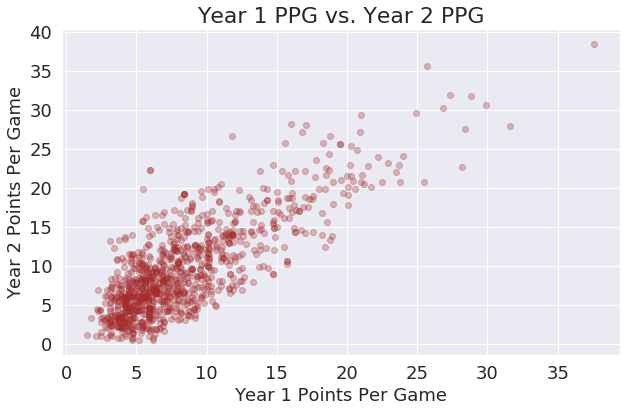

In [22]:
# Perhaps predictably, rookie year ppg is strongly correlated to sophomore ppg

plt.figure(figsize=(10,6))

plt.scatter(df['Rookie PPG'], df['Sophomore PPG'], alpha = 0.3, c='brown')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Year 1 Points Per Game', fontsize = 18)
plt.ylabel('Year 2 Points Per Game', fontsize = 18)
plt.title('Year 1 PPG vs. Year 2 PPG', fontsize = 22);

plt.savefig('../figures/Year 1 PPG vs. Year 2 PPG.png')

### Account for possible polynomial interactions (visualized in pairplot) and organize data for modeling

In [23]:
# Features = Rookie Stats
# Target = Sophomore points per game

features, target = ['Rookie PPG', 'FGA',  'FG_Pct', 'Games Played', 'MPG', 'Rebounds',
                     'Assists', 'Steals', '3 Pt. Att', 'FT Pct'], ['Sophomore PPG']

X, y = df[features], df[target].values

# Account for possible quadratic relationships
X['gp2'] = X['Games Played']** 2
X['rb2'] = X['Rebounds'] ** 2
X['fga2'] = X['FGA'] ** 2
X['ppg2'] = X['Rookie PPG'] ** 2

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

### Baseline score

In [24]:
baseline = LinearRegression()
baseline.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [25]:
baseline.score(X_test, y_test)

0.638341711953279

### Normalize data

In [26]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [27]:
alphavec = 10**np.linspace(-5,5,200)

### Ridge

In [28]:
ridge = RidgeCV(alphas = alphavec, cv=5).fit(X_train, y_train)
ridge_alpha = ridge.alpha_

In [29]:
ridge_regression = Ridge(alpha = ridge_alpha).fit(X_train, y_train)
ridge_regression.score(X_test, y_test)

0.6401389207414202

### Lasso

In [30]:
lasso = LassoCV(alphas = alphavec, cv=5).fit(X_train, y_train)
lasso_alpha = lasso.alpha_

In [31]:
lasso_regression = Lasso(alpha = lasso_alpha).fit(X_train, y_train)
lasso_regression.score(X_test, y_test)

0.6416632476117408

### Predicted Vs. Actual

In [32]:
preds = lasso_regression.predict(X_test)
preds = preds.reshape(200,1)

In [42]:
# Average error of 2.7 points

mean_absolute_error(y_test, preds)

2.717536267108427

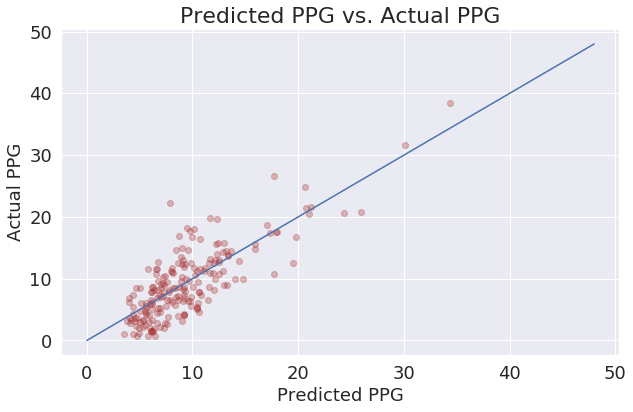

In [35]:
plt.figure(figsize=(10, 6))

plt.scatter(preds, y_test, alpha=.3, c='brown')
plt.plot(np.linspace(0,48,8), np.linspace(0,48,8))

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Predicted PPG vs. Actual PPG', fontsize=22)
plt.xlabel('Predicted PPG', fontsize=18)
plt.ylabel('Actual PPG', fontsize=18)

plt.savefig('../figures/Predicted vs. Actual.png')

### Residual Plot

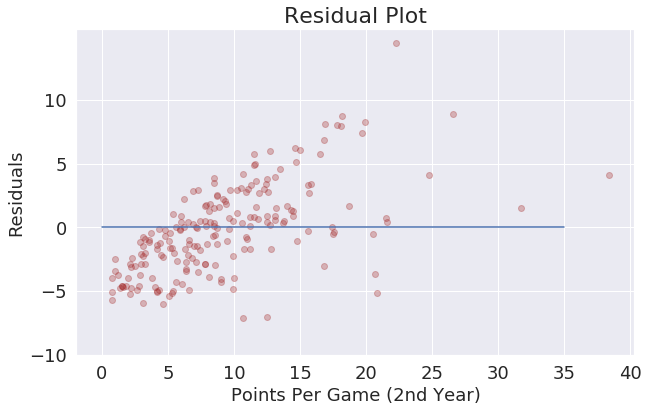

In [38]:
plt.figure(figsize=(10, 6))

plt.scatter(y_test, y_test-preds, alpha=.3, c='brown')
plt.plot(np.linspace(0,35,1000), np.linspace(0,0,1000))

plt.xticks(fontsize=18)
plt.yticks([-10, -5, 0, 5, 10], fontsize=18)
plt.title('Residual Plot', fontsize=22)
plt.xlabel('Points Per Game (2nd Year)', fontsize=18)
plt.ylabel('Residuals', fontsize=18)

plt.savefig('../figures/Residual Plot.png')